<a href="https://colab.research.google.com/github/aemrhb/IPI_project-seminar/blob/main/Detection_faster_Rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My Drive/ProSem_23/FRCNN_detection

/content/gdrive/My Drive/ProSem_23/FRCNN_detection


In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [ ]:
import torchvision

In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
# from torchvision.datasets import YourCustomDataset
from torch.optim import SGD
import torch.utils.data
import torchvision.transforms as T

In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
# from engine import train_one_epoch, evaluate
# import utils
# import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
import cv2
import os
from PIL import Image
import numpy as np
import torch
# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

In [ ]:
files_dir = '/content/gdrive/My Drive/faster-Rccn-finetune/data/Kuken_videos/Kuken_videos-00_0'

In [ ]:
imge_path = os.path.join(files_dir, "img1" )
annots_path  = os.path.join(files_dir ,"annot")

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir,width, height, transforms=None):  # Add necessary arguments for dataset initialization
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = list(sorted(os.listdir(imge_path)))





    def __getitem__(self, idx):
        # Implement dataset item retrieval logic
        imge_path = os.path.join(self.files_dir , "img1" )
        img_name = self.imgs[idx]
        img_path = os.path.join(imge_path, img_name)
        img = cv2.imread(img_path)
        wt = img.shape[1]
        ht = img.shape[0]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_res /= 255.0


        annots_path  = os.path.join(files_dir ,"annot")
        annot_file = img_name[:-4] + '.txt'
        annot_path = os.path.join(annots_path,annot_file)
        with open(annot_path, "r") as file:
          file_contents = file.read()
        lines = file_contents.split("\n")
        data = np.matrix(lines)
        boxes = []
        labels = []
        area = []

        for i in range(data.shape[1] - 1 ):
          boxe = []
          line = data[0,i].split(",")
          # print(line)
          strr = line[2:6]

          res = [float(t) for t in strr]

          xmin_corr = (res[0]/wt)*self.width
          xmax_corr = (res[0]/wt)*self.width + (res[2]/wt)*self.width
          ymin_corr = (res[1]/ht)*self.height
          ymax_corr = (res[1]/ht)*self.height + (res[3]/ht)*self.height

          are = int((res[2] - res[0]) * (res[3] - res[1]))
          area.append(are)
          boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
          labels.append(float(line[7]))


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        image_id = torch.tensor([idx])


        target = {}

        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id

        if self.transforms:

            sample = self.transforms(image = img_res)
                                    #  bboxes = target['boxes'],
                                    #  labels = labels)

            img_res = sample['image']
            # target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target


    def __len__(self):
        # Return the size of the dataset
        return len(self.imgs)


In [ ]:
# Load the pre-trained model from the cloned repository
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Set the model to evaluation mode
model.eval()


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 74.2MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
dataset = CustomDataset(files_dir, 224, 224)

In [ ]:
def get_transform(train):
    if train:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])

In [ ]:
dataset = CustomDataset(files_dir, 480, 480)
#dataset_test = CustomDataset(files_dir, 480, 480)
dataset_test = CustomDataset(files_dir,1280, 720)

#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

In [ ]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

EXPECTED OUTPUT


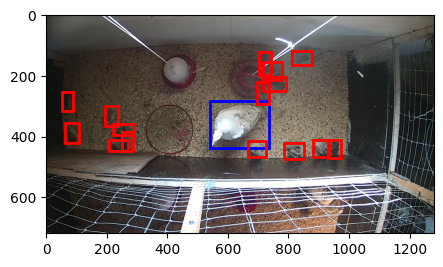

In [ ]:
def plot_img_bbox(img, target):
    # Define a color map for different classes
    color_map = {1: 'red', 2: 'blue', 3: 'green'}  # Update with your class labels and corresponding colors

    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box, label in zip(target['boxes'], target['labels']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]

        #Get the colour for the current classlabel
        color =color_map[int(label)]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = color,
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()



# plotting the image with bboxes. Feel free to change the index
img, target = dataset_test[68]
print('EXPECTED OUTPUT')
plot_img_bbox(img, target)

EXPECTED OUTPUT


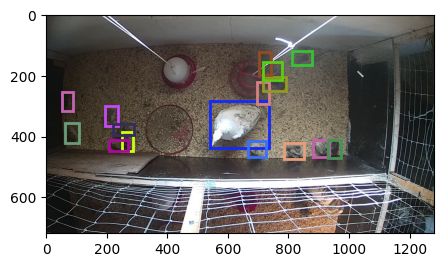

In [ ]:
def plot_img_bbox(img, target):
    # Define a color map for different classes
    color_map = {1: 'red', 2: 'blue', 3: 'green'}  # Update with your class labels and corresponding colors
    # Create a dictionary to map labels to colors
    label_colors = {}
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box, label in zip(target['boxes'], target['labels']):
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]

        # Check if the label exists in the color map dictionary
        if label in color_map:
            color = color_map[label]
        else:
            # Generate a random color for each unique label
            if label not in label_colors:
                label_colors[label] = (
                    random.random(), random.random(), random.random())
            color = label_colors[label]

        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth=2,
                                 edgecolor=color,
                                 facecolor='none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)

    plt.show()


# Example usage
img, target = dataset_test[68]
print('EXPECTED OUTPUT')
plot_img_bbox(img, target)

In [ ]:
from torchvision.transforms import ToTensor
# dataset = CustomDataset(files_dir, 224, 224)
#dataset_test = CustomDataset(files_dir, 480, 480)
dataset_test = CustomDataset(files_dir,1280, 720)
img, target = dataset_test[68]
# print(img.shape)
transform = ToTensor()
image_tensor = transform(img)

# Add a batch dimension to the tensor
image_tensor = image_tensor.unsqueeze(0)


with torch.no_grad():
    predictions = model(image_tensor)


MODEL OUTPUT


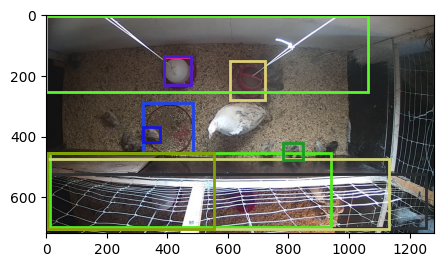

In [ ]:
prediction = predictions[0]
prediction = {key: tensor.cpu() for key, tensor in prediction.items()}
print('MODEL OUTPUT')
plot_img_bbox(img, prediction)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/My Drive/ProSem_23/FRCNN_detection

# Install necessary packages
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

# Import required libraries
import os
import random
import numpy as np
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Set random seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

# Define the path to your dataset
dataset_path = "/content/gdrive/My Drive/faster-Rccn-finetune/data/Kuken_videos/Kuken_videos-00_0"

# Define the classes in your dataset
classes = ["class1", "class2", "class3"]

# Define the custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, transforms=None):
        self.transforms = transforms
        self.dataset_path = dataset_path
        self.imgs = sorted(os.listdir(os.path.join(dataset_path, "img1")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, "img1", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        annot_path = os.path.join(self.dataset_path, "annot", self.imgs[idx][:-4] + ".txt")
        boxes, labels = self._parse_annotation(annot_path)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def _parse_annotation(self, annot_path):
        with open(annot_path, "r") as file:
            lines = file.readlines()

        boxes = []
        labels = []

        for line in lines:
            data = line.strip().split(",")
            label = int(data[7])
            if label in [1, 2, 3]:  # Filter the classes you want to detect
                xmin = float(data[2])
                ymin = float(data[3])
                width = float(data[4])
                height = float(data[5])
                xmax = xmin + width
                ymax = ymin + height
                if width > 0 and height > 0:
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(label)

        return boxes, labels

# Define the transformations
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Create the custom dataset and split it into train and test sets
dataset = CustomDataset(dataset_path, transforms=get_transform(train=True))
test_dataset = CustomDataset(dataset_path, transforms=get_transform(train=False))

# Split the dataset into train and test sets
test_split = 0.2
test_size = int(len(dataset) * test_split)
train_size = len(dataset) - test_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Define the data loaders
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: list(zip(*x)))
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: list(zip(*x)))
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: list(zip(*x)))

# Define the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = len(classes)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set training parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, targets in train_data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        # Print target labels
        print(targets)

        try:
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

            losses.backward()
            optimizer.step()
        except AssertionError as e:
            print(f"Skipping invalid bounding box: {str(e)}")


    # Update the learning rate
    lr_scheduler.step()

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss}, Val Loss: {val_loss}")

# Save the trained model
torch.save(model.state_dict(), "trained_model.pt")


Streaming output truncated to the last 5000 lines.
        [908.9700, 183.2900, 981.8300, 232.3900],
        [921.8800, 243.8400, 986.0100, 306.3500],
        [908.6000, 388.7000, 956.6000, 461.0300],
        [698.0600, 211.1300, 742.5500, 282.5500],
        [725.4100, 204.5100, 793.7100, 251.6100],
        [843.7000, 121.0000, 904.0900, 169.8000],
        [697.2200, 120.4600, 745.0900, 202.2100],
        [713.4100, 152.9500, 779.2100, 213.0500],
        [ 59.4400, 396.6600, 115.9200, 449.2800]]), 'labels': tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}]
[{'boxes': tensor([[530.2000, 287.5000, 739.0300, 415.6200],
        [ 74.8900, 123.8500, 120.3600, 158.4900],
        [242.8500, 384.7100, 284.8300, 442.6600],
        [261.5700, 408.4500, 326.6000, 448.8400],
        [284.1600, 355.1700, 358.1000, 395.9700],
        [ 86.3200, 289.1300, 151.1900, 339.5800],
        [701.4600, 418.7600, 756.2800, 465.0000],
        [781.7000, 420.1600, 847.4700, 472.4900],
        [878.5200

AttributeError: ignored